# Get waveform data

In [1]:
import os
import sys
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.inventory import Inventory
from obspy import Stream
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import base
from obspy import read, read_inventory
from obspy.io.sac import SACTrace
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#os.chdir("/Users/tongzhou/bp/coherence_measure/")
curdir = os.path.abspath(".")
print(curdir)

C:\Users\geokid\bp\coherence_measure


## set up client

"IRIS" by default 

other commonly used clients:

SCEDC: "http://service.scedc.caltech.edu"

NCEDC: "https://service.ncedc.org" 

for more, see https://docs.obspy.org/packages/obspy.clients.fdsn.html

In [2]:
client_list = ["GEONET"]
client = Client("ISC")   # set up client here for searching for the events

## search for events

In [13]:
# event search in rectangular box
# 177 -173 -14 -34
min_lon = 177               
max_lon = 180
min_lat = -34
max_lat = -14
# search in center and radius
clat = -37.5628
clon = -179.4443
min_rad = 0
max_rad = 12
min_dep = 0
max_dep = 1000
min_mag = 8.0
max_mag = 10.0
time_start = UTCDateTime("2021-03-04T00:00:00")
time_end = UTCDateTime("2021-03-05T00:00:00")
catalog = "ISC"

#cat = client.get_events(starttime=time_start,endtime=time_end,minmagnitude=min_mag,maxmagnitude=max_mag,
#                       minlatitude=min_lat,maxlatitude=max_lat,minlongitude=min_lon,maxlongitude=max_lon,
#                       mindepth=min_dep,maxdepth=max_dep,catalog=catalog)

cat = client.get_events(starttime=time_start,endtime=time_end,minmagnitude=min_mag,maxmagnitude=max_mag,
                       latitude=clat,longitude=clon,minradius=min_rad,maxradius=max_rad,
                       mindepth=min_dep,maxdepth=max_dep)


print(cat)
#cat.plot(projection='local')
#cat.plot()

1 Event(s) in Catalog:
2021-03-04T19:28:32.000000Z | -29.735, -177.282 | 8.095903088 Mw(mB) | manual


In [8]:
# get moment tensor for those events
# please fine tune the search criteria
# OUTPUT a eventid list for further use
eventid_list = []
cat2 = cat.copy()
cat.clear()
for ievt in cat2:
    origin_time = ievt.origins[0].time
    origin_mag = ievt.magnitudes[0].mag
    year = origin_time.year
    month = origin_time.month
    month_list = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    cat_cmt = obspy.read_events("https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/"+
                                str(year)+"/"+month_list[month-1]+str(year)[2:]+".ndk")
    # search for the origin time and magnitude -- might not be exactly
    for icatcmt in cat_cmt:
        o = icatcmt.origins[0].time
        m = icatcmt.magnitudes[0].mag
        if(abs(o-origin_time)<20 and abs(m-origin_mag)<0.5):
            #print(icatcmt)
            ievt.focal_mechanisms = icatcmt.focal_mechanisms
            evtid = str(icatcmt.resource_id).split("/")[2]
            print(str(ievt)+" "+evtid)
            eventid_list.append(evtid)
            cat.append(ievt)
            break


HTTPError: 404 HTTP Error: Not Found for url: https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2021/mar21.ndk

## download stations

In [15]:
# client list
client_list = ["GEONET"]
# network_list
net_list = ["*"]
# channel list
channel_list = ["*"]
# station search region (by rectangle)
sta_maxlat = 55
sta_minlat = 20
sta_maxlon = -95
sta_minlon = -125
# station search region (by circle)
center_lat = -37.5628
center_lon = -179.4443
#center_lon = -110  # west US 
sta_radius = 10
# station search time span
time_before = 86400*2
time_after = 86400
# record time span for download (seconds before and after P arrival)
record_s = 300
record_e = 600


# loop for events
for ievt in range(0,len(cat)):
    inv = Inventory()
    eventsori = cat[ievt].origins[0]
    origin_time = eventsori.time
    origin_lat = eventsori.latitude
    origin_lon = eventsori.longitude
    
    for icl in client_list:
    
        client = Client("GEONET")
        
        for inet in net_list:
            
            for ichan in channel_list:
                
                try:
        
                    inv += client.get_stations(network="*",station="*",starttime=origin_time-time_before,endtime=origin_time+time_after,
                                  latitude=center_lat,longitude=center_lon,minradius=0,maxradius=sta_radius,
                                  channel="*HZ",level="response")
                except:
                    
                    print("no response for this network")
                    continue
                    
    print(eventsori)
    print(inv)
    #inv.plot()
    


C:\Users\geokid\anaconda3\envs\pytorch1.1\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Origin
	       resource_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin/20210310201211.793202.152828")
	              time: UTCDateTime(2021, 3, 4, 19, 28, 32)
	         longitude: -177.282
	          latitude: -29.735
	             depth: 26000.0
	           quality: OriginQuality(standard_error=9.332844039)
	   evaluation_mode: 'manual'
	 evaluation_status: 'confirmed'
	     creation_info: CreationInfo(agency_id='WEL(GNS_Primary)', author='agomez@kseqx02.geonet.org.nz', creation_time=UTCDateTime(2021, 3, 10, 20, 12, 11, 793272))
	              ---------
	          arrivals: 147 Elements
Inventory created at 2021-03-11T23:23:46.332728Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: GeoNet,ObsPy 1.2.2 (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (179):
			NZ.ABAZ (Army Bay)
			NZ.AKCZ (Akaroa Harbour)
			NZ.ALRZ (Allen Road)
			NZ.AMCZ (Amberley)
			NZ.ANWZ (Angora Road)
			NZ.ARAZ (Aratiatia Landcorp Farm)
			NZ.ARCZ (Arundel)
			NZ.ARHZ 

In [16]:
eventid_list=["202103041928"]

In [17]:
inv[0][0].channels[0].code

'EHZ'

## Download waveforms

In [18]:
# loop for events
#client_list = ["ODC","GFZ","NIEP","RESIF","INGV","ETH"]
pre_filt = [0.005, 0.01, 10, 20]   # pre-filter for remove response # I use this to avoid ringing effect
output_resp = False
output_type = 'VEL'
resample_sr = 20
channel_list=["HHZ","EHZ","LHZ"]

ievt = -1
for evtid in eventid_list:
    inv = Inventory()
    st = Stream()
    print(evtid)
    if(not os.path.exists(evtid)):
        os.mkdir(evtid)
    os.chdir(evtid)
    ievt += 1
    eventsori = cat[ievt].origins[0]
    origin_time = eventsori.time
    origin_lat = eventsori.latitude
    origin_lon = eventsori.longitude
    origin_dep = eventsori.depth / 1000   # in [km]
    origin_mag = cat[ievt].magnitudes[0].mag
    print(origin_time)
    
    for icl in client_list:
    
        client = Client(icl)
        
#        for inet in net_list:
            
        for ichan in channel_list:
                
                try:
        
                    inv += client.get_stations(starttime=origin_time-time_before,endtime=origin_time+time_after,
                                  latitude=center_lat,longitude=center_lon,minradius=0,maxradius=sta_radius,
                                  channel=ichan,level="response")
                except:
                    
                    print("no response for this network")
                    continue
    #print(inv)
        
    # get waveforms
    for net in inv:       # for all networks
        for sta in net:   # for stations in the current network
            try:
                rdis = base.calc_vincenty_inverse(origin_lat,origin_lon,sta.latitude,sta.longitude)
                rdis = base.kilometer2degrees(rdis[0]/1000) # [m] to [degree] 
                #print(rdis)
                #print(origin_dep)
                P_arrival = model.get_travel_times(source_depth_in_km=origin_dep,
                                                   distance_in_degree=rdis,
                                                   phase_list=["P","pP"])
                
                #record_time = origin_time + P_arrival[0].time
                record_time = origin_time
                for ichan in sta.channels:
                    st += client.get_waveforms(net.code,sta.code, "*", ichan.code,
                                           record_time-record_s, record_time+record_e) # get waveform
                    print("st")
                    print(st)
                print(origin_time,record_time)
            except:
                pass

            # remove instrument response
            for tr in st:
                try:
                    tr.remove_response(inventory=inv, pre_filt=pre_filt, output=output_type,
                               water_level=60, plot=False)
                except:
                    print("remove response failed, remove this trace ...")
                    st.remove(tr)
                    pass
                # resample
                tr.resample(resample_sr)
                try:
                    coordinate=inv.get_coordinates(tr.id)
#                 if(tr.id.split(".")[3][-1]=='E'):
#                     cmpaz = 90
#                     cmpinc = 90
#                 elif(tr.id.split(".")[3][-1]=='N'):
#                     cmpaz = 0
#                     cmpinc = 90
#                 else:
#                     cmpaz = 0
#                     cmpinc = 0
                    cmpaz = 0
                    cmpinc = 0
                    sacheader = {'kstnm': tr.id.split(".")[1], 'knetwk':tr.id.split(".")[0], 'kcmpnm': tr.id.split(".")[3],
                            'stla':coordinate["latitude"],'stlo':coordinate["longitude"],'stel':coordinate["elevation"],
                            'stdp':coordinate["local_depth"],'cmpaz':cmpaz,'cmpinc':cmpinc,
                            'evla':origin_lat,'evlo':origin_lon,'evdp':origin_dep,'mag':origin_mag,'kevnm':evtid,
                            'nzyear':record_time.year,'nzjday':record_time.julday,'nzhour':record_time.hour,
                            'nzmin':record_time.minute,'nzsec':record_time.second,'nzmsec':record_time.microsecond/1000,
                            'lcalda':True,'delta':tr.stats.delta,'iztype':'ia','a':record_s,'ka':"P"}
                    sactr = SACTrace(data=tr.data,**sacheader)
                    print("writing trace to sac "+evtid+" "+tr.id)
                    sactr.write(tr.id + ".SAC")
                except:
                    pass
               
        
            ###  REMEBER to reset stream (waveform traces)
            st = Stream()
    
    # go to parent dir
    os.chdir("..")

202103041928
2021-03-04T19:28:32.000000Z


C:\Users\geokid\anaconda3\envs\pytorch1.1\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
C:\Users\geokid\anaconda3\envs\pytorch1.1\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
C:\Users\geokid\anaconda3\envs\pytorch1.1\lib\site-packages\obspy\io\stationxml\core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


st
1 Trace(s) in Stream:
NZ.BFZ.10.HHZ | 2021-03-04T19:23:31.998396Z - 2021-03-04T19:38:31.998396Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.BFZ.10.HHZ


C:\Users\geokid\anaconda3\envs\pytorch1.1\lib\site-packages\obspy\io\sac\arrayio.py:511: UserWarning: Non-integers may be truncated: nzmsec = 0.0
  warnings.warn(msg.format(hdr, value))


st
1 Trace(s) in Stream:
NZ.BKZ.10.HHZ | 2021-03-04T19:23:31.998393Z - 2021-03-04T19:38:31.998393Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.BKZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.COVZ.10.HHZ | 2021-03-04T19:23:31.998396Z - 2021-03-04T19:38:31.998396Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.COVZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.CTZ.10.HHZ | 2021-03-04T19:23:31.998386Z - 2021-03-04T19:38:31.998386Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.CTZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.CVZ.10.HHZ | 2021-03-04T19:23:32.003127Z - 2021-03-04T19:38:32.003127Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.CVZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.DSZ.10.HHZ | 2021-03-04T19:23:32.003130Z - 2021-03-04T

writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
writing trace to sac

writing trace to sac 202103041928 NZ.GLKZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.GRZ.10.HHZ | 2021-03-04T19:23:32.003133Z - 2021-03-04T19:38:32.003133Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.GRZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.HAZ.10.HHZ | 2021-03-04T19:23:32.003130Z - 2021-03-04T19:38:32.003130Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.HAZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.HIZ.10.HHZ | 2021-03-04T19:23:31.998393Z - 2021-03-04T19:38:31.998393Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.HIZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.INZ.10.HHZ | 2021-03-04T19:23:32.003128Z - 2021-03-04T19:38:32.003128Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.INZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.KHEZ.10

st
1 Trace(s) in Stream:
NZ.WCZ.10.HHZ | 2021-03-04T19:23:32.003132Z - 2021-03-04T19:38:32.003132Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WCZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.WEL.10.HHZ | 2021-03-04T19:23:32.003132Z - 2021-03-04T19:38:32.003132Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WEL.10.HHZ
st
1 Trace(s) in Stream:
NZ.WHVZ.10.HHZ | 2021-03-04T19:23:32.003131Z - 2021-03-04T19:38:32.003131Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WHVZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2021-03-04T19:23:32.003121Z - 2021-03-04T19:38:32.003121Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WIZ.10.HHZ
st
1 Trace(s) in Stream:
NZ.WSRZ.10.HHZ | 2021-03-04T19:23:32.003130Z - 2021-03-04

writing trace to sac 202103041928 NZ.HSRZ.10.EHZ
writing trace to sac 202103041928 NZ.HSRZ.10.EHZ
writing trace to sac 202103041928 NZ.HSRZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.KARZ.10.EHZ | 2021-03-04T19:23:32.003137Z - 2021-03-04T19:38:32.003137Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.KARZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.KBAZ.10.EHZ | 2021-03-04T19:23:32.003116Z - 2021-03-04T19:38:32.003116Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.KBAZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.KIW.10.EHZ | 2021-03-04T19:23:32.003134Z - 2021-03-04T19:38:32.003134Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.KIW.10.EHZ
st
1 Trace(s) in Stream:
NZ.KMRZ.10.EHZ | 2021-03-04T19:23:32.003132Z - 2021-03-04T19:38:32.003132Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-

st
1 Trace(s) in Stream:
NZ.OKCZ.10.EHZ | 2021-03-04T19:23:31.998391Z - 2021-03-04T19:38:31.998391Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.OKCZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.OMRZ.10.EHZ | 2021-03-04T19:23:31.998389Z - 2021-03-04T19:38:31.998389Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.OMRZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.PAWZ.10.EHZ | 2021-03-04T19:23:32.003129Z - 2021-03-04T19:38:32.003129Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.PAWZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.PKGZ.10.EHZ | 2021-03-04T19:23:32.000002Z - 2021-03-04T19:38:32.000002Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.PKGZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.PKVZ.10.EHZ | 2021-03-04T19:23:32.000000Z - 2021

st
1 Trace(s) in Stream:
NZ.UTU.10.EHZ | 2021-03-04T19:23:32.000004Z - 2021-03-04T19:38:32.000004Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.UTU.10.EHZ
st
1 Trace(s) in Stream:
NZ.WACZ.10.EHZ | 2021-03-04T19:23:31.998394Z - 2021-03-04T19:38:31.998394Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WACZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.WATZ.10.EHZ | 2021-03-04T19:23:31.998411Z - 2021-03-04T19:38:31.998411Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WATZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.WHHZ.10.EHZ | 2021-03-04T19:23:31.998383Z - 2021-03-04T19:38:31.998383Z | 100.0 Hz, 90001 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.WHHZ.10.EHZ
st
1 Trace(s) in Stream:
NZ.WHRZ.10.EHZ | 2021-03-04T19:23:31.998393Z - 2021-0

st
1 Trace(s) in Stream:
NZ.OTVZ.10.LHZ | 2021-03-04T19:23:32.071825Z - 2021-03-04T19:38:32.071825Z | 1.0 Hz, 901 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.OTVZ.10.LHZ
st
1 Trace(s) in Stream:
NZ.OUZ.10.LHZ | 2021-03-04T19:23:32.071856Z - 2021-03-04T19:38:32.071856Z | 1.0 Hz, 901 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.OUZ.10.LHZ
st
1 Trace(s) in Stream:
NZ.OXZ.10.LHZ | 2021-03-04T19:23:32.071860Z - 2021-03-04T19:38:32.071860Z | 1.0 Hz, 901 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.OXZ.10.LHZ
st
1 Trace(s) in Stream:
NZ.PUZ.10.LHZ | 2021-03-04T19:23:32.069538Z - 2021-03-04T19:38:32.069538Z | 1.0 Hz, 901 samples
2021-03-04T19:28:32.000000Z 2021-03-04T19:28:32.000000Z
writing trace to sac 202103041928 NZ.PUZ.10.LHZ
st
1 Trace(s) in Stream:
NZ.PXZ.10.LHZ | 2021-03-04T19:23:32.072004Z - 2021-03-04T19:38:32.072004Z

In [36]:
client=Client("GEONET")
print(origin_time)

2021-03-04T13:27:36.464000Z


In [43]:
st= client.get_waveforms("NZ","ABAZ", "*", "*",UTCDateTime("2021-03-04T13:28:00"), UTCDateTime("2021-03-04T13:32:00"))

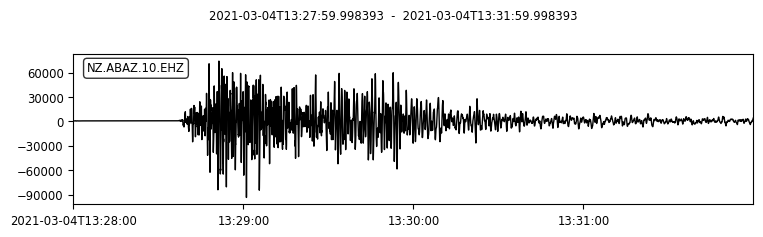

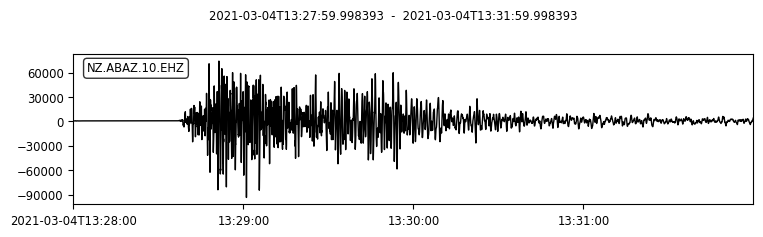

In [44]:
st[7].plot()

In [9]:
os.chdir("..")